# Download data

In [ ]:
!wget https://covid19.ncsc.gov.vn/api/v3/covid/national_total -O national_total

--2022-01-19 01:50:25--  https://covid19.ncsc.gov.vn/api/v3/covid/national_total
Resolving covid19.ncsc.gov.vn (covid19.ncsc.gov.vn)... 103.192.236.174
Connecting to covid19.ncsc.gov.vn (covid19.ncsc.gov.vn)|103.192.236.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491183 (480K) [application/json]
Saving to: ‘national_total’

national_total      100%[===================>] 479.67K   488KB/s    in 1.0s    

2022-01-19 01:50:28 (488 KB/s) - ‘national_total’ saved [491183/491183]



# Preprocessing

In [ ]:
import datetime as dt
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

## Loading raw data

In [ ]:
raw = json.load(open('national_total'))
print(list(raw.keys()))

['new_case', 'new_death', 'new_recovered', 'new_active', 'total_case', 'total_death', 'total_active', 'total_recovered', 'case_by_day', 'case_by_time', 'active_by_day', 'active_by_time', 'death_by_day', 'death_by_time', 'recovered_by_day', 'recovered_by_time', 'compare_active_7_days_before', 'compare_case_7_days_before', 'compare_death_7_days_before', 'compare_recovered_7_days_before', 'active_/_100000', 'case_/_100000', 'death_/_100000', 'recovered_/_100000', 'percent_active_/_100000', 'percent_death_/_100000', 'percent_case_/_100000', 'percent_recovered_/_100000', 'percent_recovered_/_sum_case', 'prediction', 'last_updated']


Getting the necessary fields.

In [ ]:
keys_to_get = [
  'case_by_day', 'case_by_time',
  'death_by_day', 'death_by_time',
  'recovered_by_day', 'recovered_by_time',
  'active_by_day', 'active_by_time'
]

d = dict()
for key in keys_to_get:
    d[key] = raw[key]

In [ ]:
df = pd.DataFrame.from_records(d)
df.index = df.index.map(lambda x: dt.datetime.strptime(x, '%d/%m/%Y'))
df = df[df.index <= dt.datetime(2022, 1, 18)]
df.sort_index(inplace=True)

General descriptive statistics about the data.

In [ ]:
df.describe()

,active_by_day,active_by_time,case_by_day,case_by_time,death_by_day,death_by_time,recovered_by_day,recovered_by_time
count,267.00,267.00,414.00,414.00,414.00,414.00,414.00,414.00
mean,"1,215.19","133,305.40","4,954.51","409,457.43",85.74,"8,587.90","4,240.98","314,793.59"
std,"8,675.99","120,512.45","6,499.77","576,758.49",125.65,"11,655.13","8,787.57","467,575.78"
min,"-75,236.00",303.00,0.00,"1,351.00",0.00,35.00,0.00,"1,195.00"
25%,74.50,"10,980.00",9.00,"2,554.75",0.00,35.00,0.25,"2,093.25"
50%,"1,388.00","112,599.00",309.00,"14,906.00",1.00,74.00,78.00,"6,043.00"
75%,"4,424.00","216,006.50","9,567.75","825,950.00",173.75,"20,191.75","4,426.75","758,134.50"
max,"37,931.00","415,765.00","39,132.00","2,062,128.00",804.00,"35,972.00","89,842.00","1,756,154.00"


The following figures show the pandemic situation in Vietnam since December 2020. As you can see, starting from July 2021 - the beginning of the fourth outbreak - all of the statistics raise, far exceed the previous periods. Given these characteristics of the dataset, we decided to truncate the data so that we include the data since October 2021 only. Here are the main reasons:
* The previous three outbreaks together span over a long time range, which can greatly affect the accuracy of the model if it is to be kept back and integrated into the prediction. Removing the records older than July 2021 is thus appropriate since it eliminates this effect and helps the prediction adjust better for the recent events.
* We also remove the data in July-September 2021 with the similar reason. October is the start of the post-confinement period when the country resumes normal economic activities. We can see the effect in the figure, where the number of active cases (orange) has a big drop at the end of September, and then starts to grow afterward.


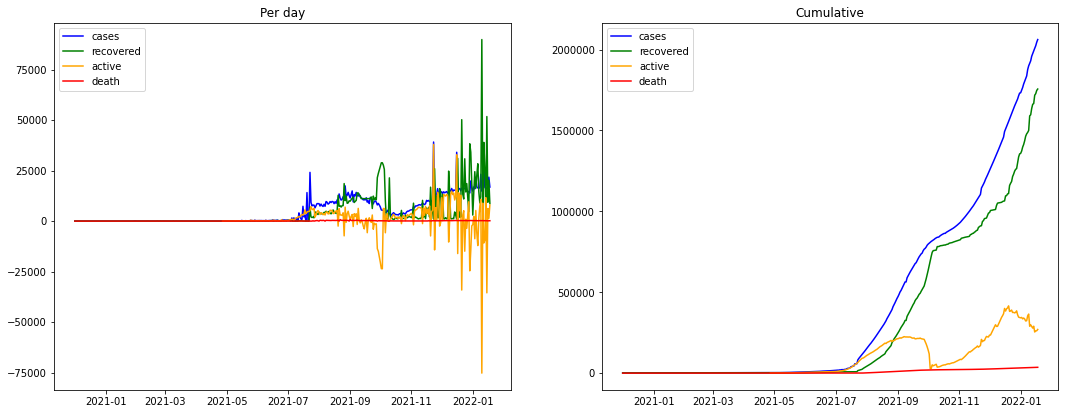

In [ ]:
fig_data_raw, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6.75))
ax.plot(df.index, df.case_by_day, color='b', label='cases')
ax.plot(df.index, df.recovered_by_day, color='g', label='recovered')
ax.plot(df.index, df.active_by_day, color='orange', label='active')
ax.plot(df.index, df.death_by_day, color='r', label='death')
ax.set_title('Per day')
ax.legend()

ax2.plot(df.index, df.case_by_time, color='b', label='cases')
ax2.plot(df.index, df.recovered_by_time, color='g', label='recovered')
ax2.plot(df.index, df.active_by_time, color='orange', label='active')
ax2.plot(df.index, df.death_by_time, color='r', label='death')
ax2.set_title('Cumulative')
ax2.ticklabel_format(axis='y', style='plain')
ax2.legend()

plt.show()

In [ ]:
df = df[df.index >= dt.datetime(2021, 10, 1)]

Here is the graph after removal.

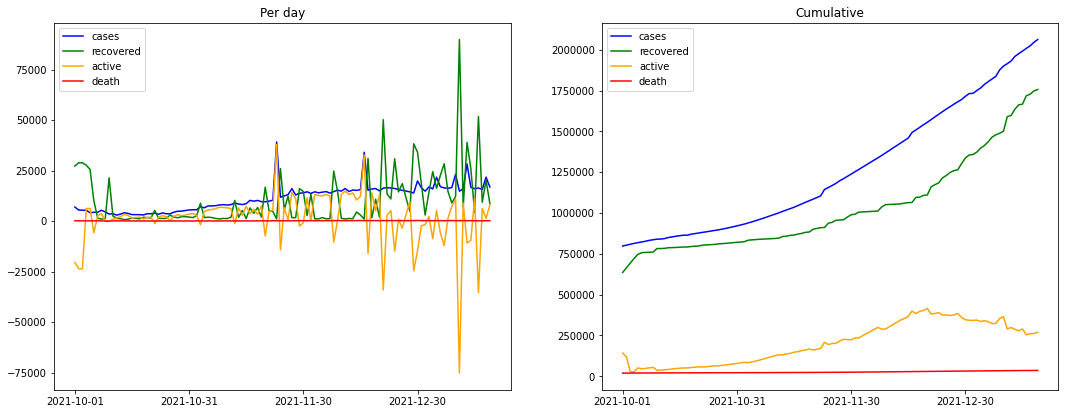

In [ ]:
fig_data_removed, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6.75))
ax.plot(df.index, df.case_by_day, color='b', label='cases')
ax.plot(df.index, df.recovered_by_day, color='g', label='recovered')
ax.plot(df.index, df.active_by_day, color='orange', label='active')
ax.plot(df.index, df.death_by_day, color='r', label='death')
ax.set_title('Per day')
ax.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax.legend()

ax2.plot(df.index, df.case_by_time, color='b', label='cases')
ax2.plot(df.index, df.recovered_by_time, color='g', label='recovered')
ax2.plot(df.index, df.active_by_time, color='orange', label='active')
ax2.plot(df.index, df.death_by_time, color='r', label='death')
ax2.set_title('Cumulative')
ax2.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax2.ticklabel_format(axis='y', style='plain')
ax2.legend()
plt.show()

Next, we check for inconsistencies within the dataset. By definition, the `active_by_time` can be computed by the formula `case_by_time - recovered_by_time - death_by_time`.

Here we've compared the `active_by_time` column with the difference according to the formula. There is only a slight inconsistency in the first few days. We speculate that the reason of this error is due to the transition of the country to the "new normal" state. The rest perfectly fits the formula. Thus, we decide to replace the `active_by_time` column with the values computed by the formula.

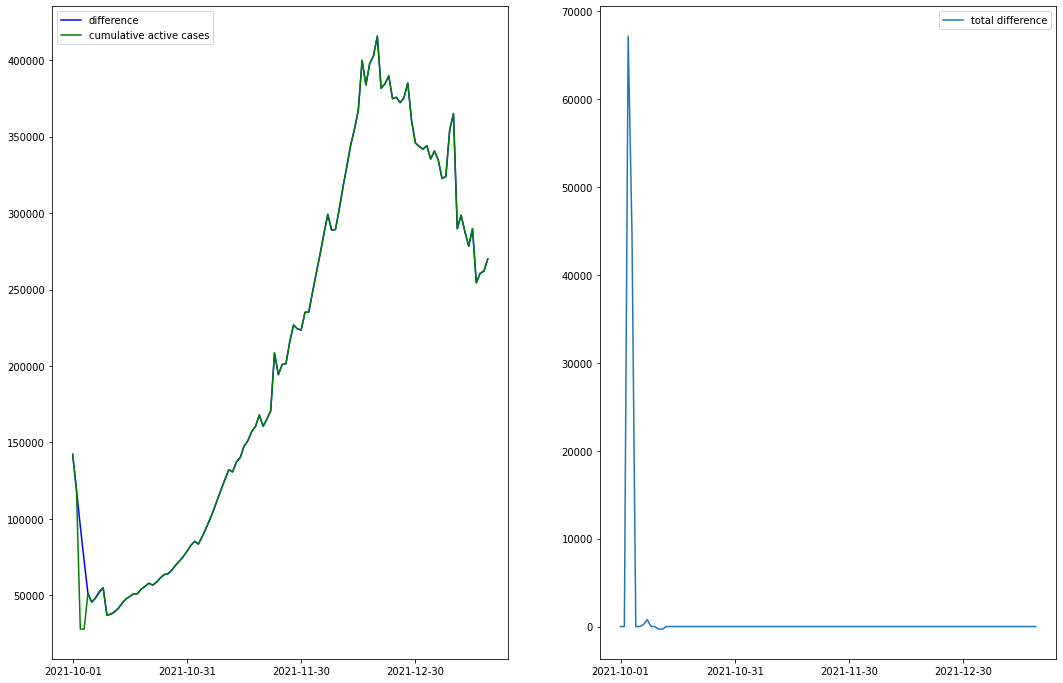

In [ ]:
fig_active_modification, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 12))
ax.plot(df.index, df.case_by_time - df.recovered_by_time - df.death_by_time, color='b', label='difference')
ax.plot(df.index, df.active_by_time, color='g', label='cumulative active cases')
ax.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax.legend()

ax2.plot(df.index, df.case_by_time - df.recovered_by_time - df.death_by_time - df.active_by_time, label='total difference')
ax2.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax2.legend()
plt.show()

In [ ]:
df.active_by_time = df.case_by_time - df.recovered_by_time - df.death_by_time

## Smoothing data

We use the moving average smoothing technique for data preparation, with the window size is 7 days. The graph shows the data after smoothing.

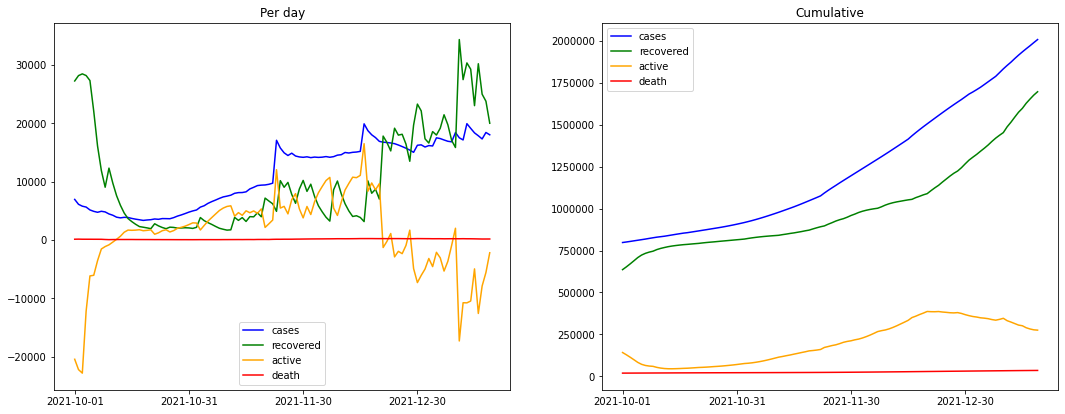

In [ ]:
fig_data_smoothed, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6.75))
tf = df.ewm(span=7).mean()

ax.plot(tf.index, tf.case_by_day, color='b', label='cases')
ax.plot(tf.index, tf.recovered_by_day, color='g', label='recovered')
ax.plot(tf.index, tf.active_by_day, color='orange', label='active')
ax.plot(tf.index, tf.death_by_day, color='r', label='death')
ax.set_title('Per day')
ax.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax.legend()

ax2.plot(tf.index, tf.case_by_time, color='b', label='cases')
ax2.plot(tf.index, tf.recovered_by_time, color='g', label='recovered')
ax2.plot(tf.index, tf.active_by_time, color='orange', label='active')
ax2.plot(tf.index, tf.death_by_time, color='r', label='death')
ax2.set_title('Cumulative')
ax2.set_xticks(np.arange(df.index.min(), df.index.max(), dt.timedelta(days=30)))
ax2.ticklabel_format(axis='y', style='plain')
ax2.legend()
plt.show()

In [ ]:
df = df.ewm(span=7).mean()

# The SIRD model and simulation

In this section, we model the COVID-19 pandemic in Vietnam using a classical SIR model, with an enhancement to include a death state.

A state is represented by a group of $(S_t, I_t, R_t, D_t)$, where $S_t$, $I_t$, $R_t$, $D_t$ are the number of susceptible individuals, the number of active cases (infected individuals), the cumulative number of recovered cases, and the cumulative number of death cases at time $t$, respectively.

The transition of a state is given by the formula:
$$
\begin{align*}
S_{t+1} &= S_t - \beta S_t \\
I_{t+1} &= I_t + \beta S_t - \gamma I_t - \mu I_t \\
R_{t+1} &= R_t + \gamma I_t \\
D_{t+1} &= D_t + \mu I_t
\end{align*}
$$

where:
* $\beta$ is the rate of infection
* $\gamma$ is the rate of recovery
* $\mu$ is the death rate of the infection

Since we don't know for sure the parameters $\beta$, $\gamma$ and $\mu$, we will approximate them using the given data.

We provide the approximation as follow:
* $\beta \approx \frac{\text{number of new cases}}{\text{number of susceptible individuals}}$
* $\gamma \approx \frac{\text{number of new recovered cases}}{\text{number of infected cases}}$
* $\mu \approx \frac{\text{number of new death cases}}{\text{number of infected cases}}$

Consider approximating $\beta$:
* For each day $t$, we calculate the rate of infection of day $t$
$$\beta_t = \frac{\text{number of new cases in day t}}{\text{number of susceptible individuals in day t}}$$
* We approximate $\beta$ by taking the average of the rate of infection per day
$$\beta = \frac{1}{n}\sum {\beta_t}$$

The same approach can be applied to $\gamma$ and $\mu$.

_Note_: we don't have the data for the number of susceptible individuals in a day, but it can be calculated with the formula `N - case_by_time`. `N` here is the population of Vietnam, which we assume to be constant and is equal to 98,678,083.

In [ ]:
N = 98678083
gamma = (df.recovered_by_day / df.active_by_time).mean()
beta = (df.case_by_day / (N - df.case_by_time)).mean()
mu = (df.death_by_day / df.active_by_time).mean()
print(gamma, beta, mu)

0.06371672083747516 0.00011453330803204832 0.0008969314780335654


Next, we define the necessary functions for the simulation.
* The `next_state` function takes in the current state, necessary parameters and returns the next state computed according to the formula given above.
* The `simulation` function takes in a starting state and repeat the `next_state` function with the parameters for a given number of `days`. It returns a list of predicted states.

In [ ]:
def next_state(s, beta, gamma, mu):
  return np.array([
    s[0] - beta * s[0],
    s[1] + beta * s[0] - gamma * s[1] - mu * s[1],
    s[2] + gamma * s[1],
    s[3] + mu * s[1]
  ])

def simulation(start, beta, gamma, mu, days):
  r = []
  s = start
  for i in range(days):
    s = next_state(s, beta, gamma, mu)
    r.append(s)
  return r

We simulate the model, starting from the latest date in the data. We run the simulation for a period of 30 days. After that, we combine the result into a `DataFrame`, modify its columns so that it matches the schema of the data we're having. Specifically, we will
* Recompute the `case_by_time` column we have left out when we model the state.
* Reindex the resulted `DataFrame` to match that of `df`.

In [ ]:
# Latest date
interested_columns = ['active_by_time', 'recovered_by_time', 'death_by_time', 'case_by_time']
last = df.iloc[-1, :][interested_columns]
start = np.array(
    [N - last.active_by_time - last.recovered_by_time - last.death_by_time, 
     last.active_by_time,
     last.recovered_by_time,
     last.death_by_time]
)

def make_prediction(start, beta, gamma, mu, days):
  predicted = pd.DataFrame(simulation(start, beta, gamma, mu, days))
  predicted = predicted[[1, 2, 3]]
  predicted.insert(3, 4, predicted[1] + predicted[2] + predicted[3])
  predicted.columns = interested_columns

  # last.name is the date of the starting state
  predicted.index = predicted.index.map(lambda x: last.name + dt.timedelta(days=x+1))
  return predicted

# predicted = pd.DataFrame(simulation(start, beta, gamma, mu, 30))
# predicted = predicted[[1, 2, 3]]
# predicted.insert(3, 4, predicted[1] + predicted[2] + predicted[3])
# predicted.columns = interested_columns

# # last.name is the date of the starting state
# predicted.index = predicted.index.map(lambda x: last.name + dt.timedelta(days=x+1))
predicted = make_prediction(start, beta, gamma, mu, 30)
predicted

,active_by_time,recovered_by_time,death_by_time,case_by_time
2022-01-19,"268,844.59","1,713,688.37","35,690.89","2,018,223.86"
2022-01-20,"262,544.33","1,730,818.27","35,932.03","2,029,294.63"
2022-01-21,"256,649.89","1,747,546.73","36,167.51","2,040,364.14"
2022-01-22,"251,135.04","1,763,899.62","36,397.71","2,051,432.37"
2022-01-23,"245,975.26","1,779,901.12","36,622.96","2,062,499.34"
2022-01-24,"241,147.60","1,795,573.86","36,843.58","2,073,565.05"
2022-01-25,"236,630.61","1,810,939.00","37,059.88","2,084,629.48"
2022-01-26,"232,404.21","1,826,016.32","37,272.12","2,095,692.65"
2022-01-27,"228,449.62","1,840,824.36","37,480.57","2,106,754.55"
2022-01-28,"224,749.29","1,855,380.42","37,685.47","2,117,815.18"


Finally, we combine `predicted` with desired columns of `df` and plot the results.

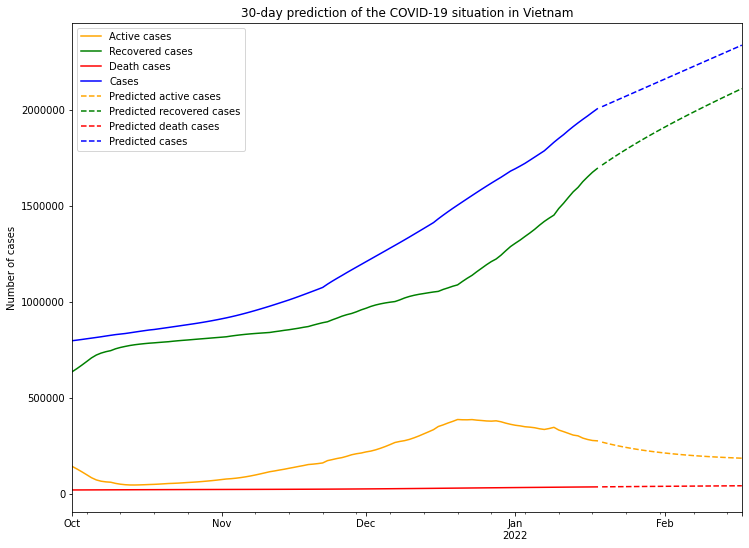

In [ ]:
final = pd.concat([
  df[interested_columns],
  predicted]
)

fig_predicted, ax = plt.subplots(figsize=(12, 9))

final[final.index <= last.name].plot(ax=ax, color=['orange', 'g', 'r', 'b'])
final[final.index > last.name].plot(ax=ax, style='--', color=['orange', 'g', 'r', 'b'])
ax.legend(
    ['Active cases', 'Recovered cases', 'Death cases', 'Cases',
     'Predicted active cases', 'Predicted recovered cases', 'Predicted death cases', 'Predicted cases'])
ax.set_ylabel('Number of cases')
ax.set_title('30-day prediction of the COVID-19 situation in Vietnam')
ax.ticklabel_format(axis='y', style='plain')
plt.show()

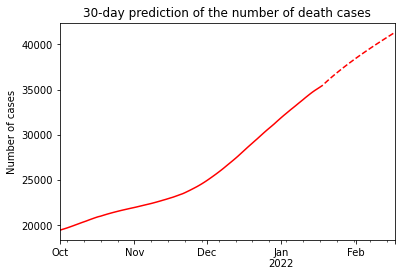

In [ ]:
fig_predicted_death, ax = plt.subplots()
predicted_death = final['death_by_time']
predicted_death[predicted_death.index <= last.name].plot(color='r')
predicted_death[predicted_death.index > last.name].plot(color='r', style='--')
ax.set_title('30-day prediction of the number of death cases')
ax.set_ylabel('Number of cases')
plt.show()

## Analysis

The followings are the changes in the number of cases, recovered cases, death, and active cases in 30-day that our model has predicted.

In [ ]:
predicted.iloc[-1, :] - last

active_by_time      -90,496.34
recovered_by_time   416,247.09
death_by_time         5,859.45
case_by_time        331,610.20
dtype: float64

Average change per day

In [ ]:
(predicted.iloc[-1, :] - last) / 30

active_by_time      -3,016.54
recovered_by_time   13,874.90
death_by_time          195.32
case_by_time        11,053.67
dtype: float64

Compare to the absolute and average change per day in one month of the data.

In [ ]:
for i in range(0, df.index.size, 30):
  block = df.iloc[i:i+30, :]
  print((block.iloc[-1, :] - block.iloc[0, :])[interested_columns] / 30, '\n')

active_by_time      -2,470.38
recovered_by_time    5,866.18
death_by_time           80.34
case_by_time         3,476.14
dtype: float64 

active_by_time      4,585.88
recovered_by_time   4,478.95
death_by_time          89.20
case_by_time        9,154.03
dtype: float64 

active_by_time       5,433.48
recovered_by_time    9,492.58
death_by_time          214.76
case_by_time        15,140.81
dtype: float64 

active_by_time      -3,074.57
recovered_by_time   14,311.68
death_by_time          133.58
case_by_time        11,370.69
dtype: float64 



Predict for a wider time range.

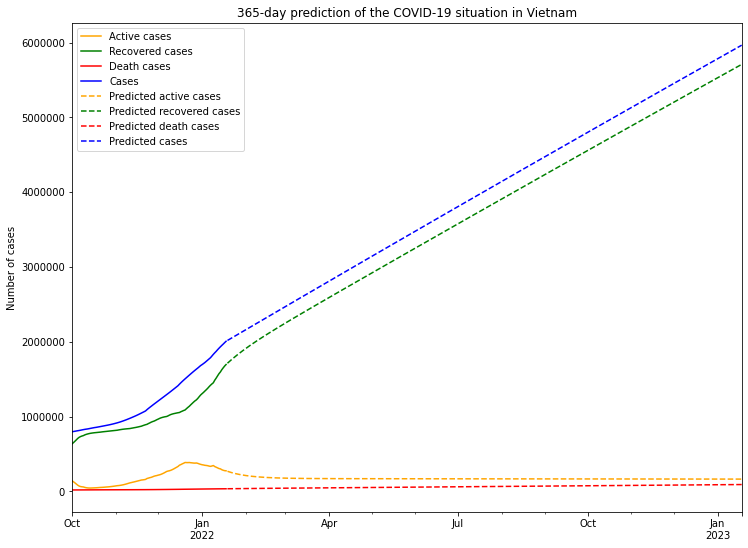

In [ ]:
predicted_wide = make_prediction(start, beta, gamma, mu, 365)
r = pd.concat([df[interested_columns], predicted_wide])

fig_predicted_wide, ax = plt.subplots(figsize=(12, 9))

r[r.index <= last.name].plot(ax=ax, color=['orange', 'g', 'r', 'b'])
r[r.index > last.name].plot(ax=ax, style='--', color=['orange', 'g', 'r', 'b'])

ax.legend(
    ['Active cases', 'Recovered cases', 'Death cases', 'Cases',
     'Predicted active cases', 'Predicted recovered cases', 'Predicted death cases', 'Predicted cases'])
ax.set_ylabel('Number of cases')
ax.set_title('365-day prediction of the COVID-19 situation in Vietnam')
ax.ticklabel_format(axis='y', style='plain')

plt.show()

# Saving figures

In [ ]:
fig_data_raw.savefig('fig_data_raw.png')
fig_data_removed.savefig('fig_data_removed.png')
fig_data_smoothed.savefig('fig_data_smoothed.png')
fig_active_modification.savefig('fig_action_modification.png')
fig_predicted.savefig('fig_predicted.png')
fig_predicted_death.savefig('fig_predicted_death.png')
fig_predicted_wide.savefig('fig_predicted_wide.png')

In [ ]:
!zip figures.zip fig_data_raw.png fig_action_modification.png fig_data_removed.png \
fig_data_smoothed.png fig_predicted.png fig_predicted_death.png fig_predicted_wide.png

updating: fig_data_raw.png (deflated 6%)
updating: fig_action_modification.png (deflated 13%)
updating: fig_predicted.png (deflated 9%)
updating: fig_predicted_death.png (deflated 7%)
updating: fig_predicted_wide.png (deflated 8%)
updating: fig_data_removed.png (deflated 5%)
updating: fig_data_smoothed.png (deflated 5%)
